In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from tqdm.notebook import tqdm
from scipy.integrate import odeint
from scipy.optimize import fsolve
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
np.random.seed(42)

NAME = 'assignment3'
DATA_PATH = f'data/{NAME}'
MEDIA_PATH = f'media/{NAME}'
[os.makedirs(path, exist_ok=True) for path in [DATA_PATH, MEDIA_PATH]]
print('Setup complete')

Setup complete


# Question 1: Complex calcium oscillations

### a) & b)

Banger vague question. My favourite.

The proposed system describing intracellular calcium oscillations is characterized by the existence of three calcium stores: the ER, mitochondria and calcium-binding proteins in the cytosol, of which ER is considered to be the main store. We denote their respective calcium concentrations as $[ Ca_{ER}], [ Ca_{m} ], [ Ca_{cyt} ]$. In addition to these three model variables we also consider the concentration of binding sites on the calcium-binding cytosolic proteins. These occur in either unbounded ($Pr$) or bounded ($CaPr$) state. The model neglects import and export through the cell membrane and thus the total concentration of both cellular calcium $Ca_{tot}$ and cytosolic proteins $Pr_{tot}$ is conserved (constant). In summary, the system differentiates four different states of calcium molecules and two states of calcium-binding molecules. This gives rise to the formulas for $Ca_{tot}$ and $Pr_{tot}$ (**ADD REF**).

$$
\begin{equation}
    Ca_{tot} = Ca_{cyt} + \frac{\rho_{ER}}{\beta_{ER}} Ca_{ER} + \frac{\rho_{m}}{\beta_{m}} Ca_{m} + CaPr
\end{equation}
$$

$$
\begin{equation}
    Pr_{tot} = Pr + CaPr
\end{equation}
$$

Parameters $\rho_{ER}, \rho_{m}, \beta_{ER}, \beta_{m}$ represent the compartmental modelling component of the system. Here, $\rho_{ER}$ and $\rho_{m}$ relate to the volume ratio between ER and cytosol and between mitochondria and cytosol, respectively (**ADD REF**). Diffusion of calcium within the ER and mitochondria is assumed to occur rapidly and thus specific spatial modelling of calcium concentration within this components is neglected. Instead, we are interested in relating the total concentration of free calcium in the ER and the mitochondria to the respective total concentrations, which is done through constant factors $\beta_{ER}$ and $\beta_{m}$ (**ADD REF**).

$$
\begin{equation}
    \rho_{ER} \sim \frac{V_{ER}}{V_{cyt}}
\end{equation}
$$

$$
\begin{equation}
    \rho_{m} \sim \frac{V_{m}}{V_{cyt}}
\end{equation}
$$

$$
\begin{equation}
    \beta_{ER} \sim \frac{[Ca_{ER}]}{[Ca_{tot}]}
\end{equation}
$$

$$
\begin{equation}
    \beta_{m} \sim \frac{[Ca_{m}]}{[Ca_{tot}]}
\end{equation}
$$

System's main calcium storage, the endoplasmic reticulum (ER), absorbs calcium in an ATP-dependent process from the surrounding cytosol ($J_{pump}$). This inflow is taken to be a linear function of cytosolic calcium (**ADD REF**) with $k_{pump}$ rate constant related to the presence of ATP-ases, enzymes catalyzing the decomposition of ATP into ADP. Efflux of calcium from the ER occurs in two ways. A calcium-induced calcium release (CICR) mechanism moderates the efflux of calcium ions $Ca^{2+}$ through excitable membrane channels ($J_{ch}$) (**ADD REF**). This process is dependent on the availability of cytosolic calcium, which is modelled by a Hill equation with coefficient $2$ and half-saturation constant $K_1$ as well as maximal permeability of $Ca^{2+}$ membrane channels, described by constant $k_{ch}$. Additionally to that we also distinguish a separate calcium ion efflux into the surrounding cytosol, the leak flux $J_{leak}$ (**ADD REF**) with rate constant $k_{leak}$. Both of these effluxes $J_{ch}$ and $J_{leak}$ depend on ER transmembrane potential, but this dependency is neglected for simplification purposes. Time-dependent change of free calcium concentration in the ER is thus governed by influx $J_{pump}$ and effluxes $J_{ch}$ and $J_{leak}$ and all of these fluxes are also dependent on volume and concetration related factors $\beta_{ER}, \rho_{ER}$ (**ADD REF**).

$$
\begin{equation}
    J_{pump} = k_{pump} Ca_{cyt}
\end{equation}
$$

$$
\begin{equation}
    J_{ch} = k_{ch} \frac{Ca_{cyt}^2}{K_1^2 + Ca_{cyt}^2} (Ca_{ER} - Ca_{cyt})
\end{equation}
$$

$$
\begin{equation}
    J_{leak} = k_{leak} (Ca_{ER} - Ca_{cyt})
\end{equation}
$$

$$
\begin{equation}
    \frac{d Ca_{ER}}{dt} = \frac{\beta_{ER}}{\rho_{ER}} (J_{pump} - J_{ch} - J_{leak})
\end{equation}
$$

The role of mitochondria in the system is the one of a slowly-leaking storage of calcium absorbed from the ER. This slow (up to $100$ times slower than the uptake) leakage then serves as a supply for intermediate exchange between the ER and the cytosolic proteins, which causes bursting calcium oscillations. A majority ($\approx 80 \%$) of calcium released from the ER is initially rapidly sequestered into the mitochondria by mitochondrial uniporters ($J_{in}$) (**ADD REF**). This inflow is modelled with a step-like kinetics and the dependence on cytosolic calcium is modelled through a Hill equation with coefficient $8$, and $K_2$ half-saturation constant. Additional factor $k_{in}$ is introduced to account for maximal permeability of uniporters. The slow leakeage $J_{out}$ (**ADD REF**) occurs in a very low-conductance state through permeability transition pores (PTPs) located in the inner membrane. The constant $k_{out}$ is the maximal rate for calcium flux through $Na^{+} / Ca^{2+}$ exchangers and PTPs in a low-conductance state and the rate constant $k_m$ accounts for non-specific leak flux. The time-dependent change of free calcium concentration in the mitochondria is thus governed by influx $J_{in}$ and efflux $J_{out}$ (**ADD REF**). Volume and concentration related factors again influence the final outcome.

$$
\begin{equation}
    J_{in} = k_{in} \frac{Ca_{cyt}^8}{K_2^8 + Ca_{cyt}^8}
\end{equation}
$$

$$
\begin{equation}
    J_{out} = (k_{out} \frac{Ca_{cyt}^2}{K_3^2 + Ca_{cyt}^2} + k_m) Ca_{m}
\end{equation}
$$

$$
\begin{equation}
    \frac{d Ca_{m}}{dt} = \frac{\beta_{m}}{\rho_{m}} (J_{in} - J_{out})
\end{equation}
$$

All of the five introduced fluxes $J_{pump}, J_{ch}, J_{leak}, J_{in}, J_{out}$ are mediated through the cytosol surrounding the ER and mitochondria. The fluxes are complementary in the sense that calcium inflowing into the ER or mitochondrium is absorbed from the cytosol and, vice versa, calcium ejected from the ER or mitochondria will freely flow in surrounding cytosol. In addition to these calcium fluxes, a reaction takes place between free calcium molecules and proteins present in the cytosol. Free calcium molecules $Ca$ bind to the sites on free cytosolic proteins $Pr$ resulting in a $CaPr$ complex. As the binding is reversible, a backward reaction also takes place. Related to this binding and unbinding process are forward and backward reaction constants $k_{+}$ and $k_{-}$. The total time-dependent change of free calcium concentration in the cytosol is thus governed by five calcium fluxes and a reversible reaction with cytosolic proteins (**ADD REF**). Since the compartment modelling constants $\beta$ and $\rho$ are expressed as ratios with regards to cytosol, these terms are not present in the final formula.

$$
\begin{equation}
    \frac{d Ca_{cyt}}{dt} = J_{ch} + J_{leak} - J_{pump} + J_{out} - J_{in} + k_{-} [CaPr] - k_{+} [Ca_{cyt}] [Pr] \\
\end{equation}
$$



### c)

The $Ca^{2+}$ channels govern the channel efflux $J_{ch}$ of calcium ions out of the ER. A genetic mutation would shut down these channels resulting in no pearmeability of $Ca^{2+}$ membrane channels $k_{ch}$ and thus no efflux $J_{ch}$:

$$ k_{ch} = 0 \implies J_{ch} = 0 . $$

As a direct consequence, the model equations would become:

$$
\begin{align*}
    \frac{d Ca_{cyt}}{dt} &= J_{leak} - J_{pump} + J_{out} - J_{in} + k_{-} [CaPr] - k_{+} [Ca_{cyt}] [Pr] \\
    \frac{d Ca_{m}}{dt} &= \frac{\beta_{m}}{\rho_{m}} (J_{in} - J_{out}) \\
    \frac{d Ca_{ER}}{dt} &= \frac{\beta_{ER}}{\rho_{ER}} (J_{pump} - J_{leak})
\end{align*}
$$

Since main calcium efflux from the ER is mediated through these membrane channels, we will observe an accumuluation of calcium in the ER. Without channel efflux, the calcium can never be rapidly sequestered in mitochondria, which in turn is resposnible for bursting calcium oscillations through the slow-leakage efflux $J_{out}$. Thus, the mutations might cause a complete lack of complex oscillations in the system's dynamics behaviour.

**TODO:** FINISH THIS (?)

### d)

From the conservation of total cellular calcium:

$$ CaPr = Ca_{tot} - Ca_{cyt} - \frac{\rho_{ER}}{\beta_{ER}} Ca_{ER} - \frac{\rho_{m}}{\beta_{m}} Ca_{m} $$

From the conservation of bound and unbound proteins:

$$ Pr = Pr_{tot} - CaPr = Pr_{tot} - Ca_{tot} + Ca_{cyt} + \frac{\rho_{ER}}{\beta_{ER}} Ca_{ER} + \frac{\rho_{m}}{\beta_{m}} Ca_{m} $$

Plugging this into the ODE system we get:

$$
\begin{align*}
    \frac{d Ca_{cyt}}{dt} &= J_{ch} J_{leak} - J_{pump} + J_{out} - J_{in} + \\ 
    & + k_{-} (Ca_{tot} - Ca_{cyt} - \frac{\rho_{ER}}{\beta_{ER}} Ca_{ER} - \frac{\rho_{m}}{\beta_{m}} Ca_{m}) - \\
    & - k_{+} [Ca_{cyt}] (Pr_{tot} - Ca_{tot} + Ca_{cyt} + \frac{\rho_{ER}}{\beta_{ER}} Ca_{ER} + \frac{\rho_{m}}{\beta_{m}} Ca_{m}) \\
    \frac{d Ca_{m}}{dt} &= \frac{\beta_{m}}{\rho_{m}} (J_{in} - J_{out}) \\
    \frac{d Ca_{ER}}{dt} &= \frac{\beta_{ER}}{\rho_{ER}} (J_{pump} - J_{ch} - J_{leak})
\end{align*}
$$

None of the flux terms depends on any of the protein concentrations, thus the system was reduced to three independet variables $Ca_{cyt}, Ca_{ER}$ and $Ca_{m}$.

### e)

In [4]:
def HillEq(L, ka, n):
    """
    Returns the Hill equation
    - L := total ligand concentraiton
    - ka := half-saturation constant
    - n := Hill coefficient
    """
    return ((L**n) / (ka**n + L**n))

def calcium_model(ca0, t, params):
    """
    ODE model for complex intracellular calcium oscillations as described in the paper by Marhl et al, 2000.
    """

    # Checking validity of input parameters
    acceptable_names = [
            "ca_tot", "pr_tot", "rho_er", "rho_m", "beta_er", "beta_m",
            "k_ch", "k_pump", "k_leak", "k_in", "k_out", "k_m", "k_plus", "k_minus", "K1", "K2", "K3"
        ]
    
    for param in params.keys():
        assert param in acceptable_names

    # Initializing model parameters as given by input or to default values
    ca_tot = params["ca_tot"] if "ca_tot" in params else 90
    pr_tot = params["pr_tot"] if "pr_tot" in params else 120

    rho_er = params["rho_er"] if "rho_er" in params else 0.01
    rho_m = params["rho_m"] if "rho_m" in params else 0.01
    beta_er = params["beta_er"] if "beta_er" in params else 0.0025
    beta_m = params["beta_m"] if "beta_m" in params else 0.0025

    k_ch = params["k_ch"] if "k_ch" in params else 4100
    k_pump = params["k_pump"] if "k_pump" in params else 20
    k_leak = params["k_leak"] if "k_leak" in params else 0.05
    k_in = params["k_in"] if "k_in" in params else 300
    k_out = params["k_out"] if "k_out" in params else 125
    k_m = params["k_m"] if "k_m" in params else 0.00625
    k_plus = params["k_plus"] if "k_plus" in params else 0.1
    k_minus = params["k_minus"] if "k_minus" in params else 0.01

    K1 = params["K1"] if "K1" in params else 5
    K2 = params["K2"] if "K2" in params else 0.8
    K3 = params["K3"] if "K3" in params else 5

    # Initial conditions
    ca_cyt, ca_er, ca_m = ca0

    # Substituting protein concentrations using moiety conservation
    capr = ca_tot - (ca_cyt + (rho_er / beta_er) * ca_er + (rho_m / beta_m) * ca_m)
    pr = pr_tot - capr

    # Calculation of fluxes
    j_pump = k_pump * ca_cyt
    j_ch = k_ch * HillEq(ca_cyt, K1, 2) * (ca_er - ca_cyt)
    j_leak = k_leak * (ca_er - ca_cyt)
    j_in = k_in * HillEq(ca_cyt, K2, 8)
    j_out = (k_out * HillEq(ca_cyt, K3, 2) + k_m) * ca_m

    # Model ODEs
    dcacyt_dt = j_ch + j_leak - j_pump + j_out - j_in + (k_minus * capr) - (k_plus * ca_cyt * pr)
    dcaer_dt = (beta_er / rho_er) * (j_pump - j_ch - j_leak)
    dcam_dt = (beta_m / rho_m) * (j_in - j_out)

    return [dcacyt_dt, dcaer_dt, dcam_dt]

In [5]:
# Time points
t = np.linspace(0, 300, 50000)

# Model parameters
k_chs = [3900, 4000, 2800]

# Initial conditions
ca_cyt0 = 0.3
ca_er0 = 0.2
ca_m0 = 1
ca0 = [ca_cyt0, ca_er0, ca_m0]

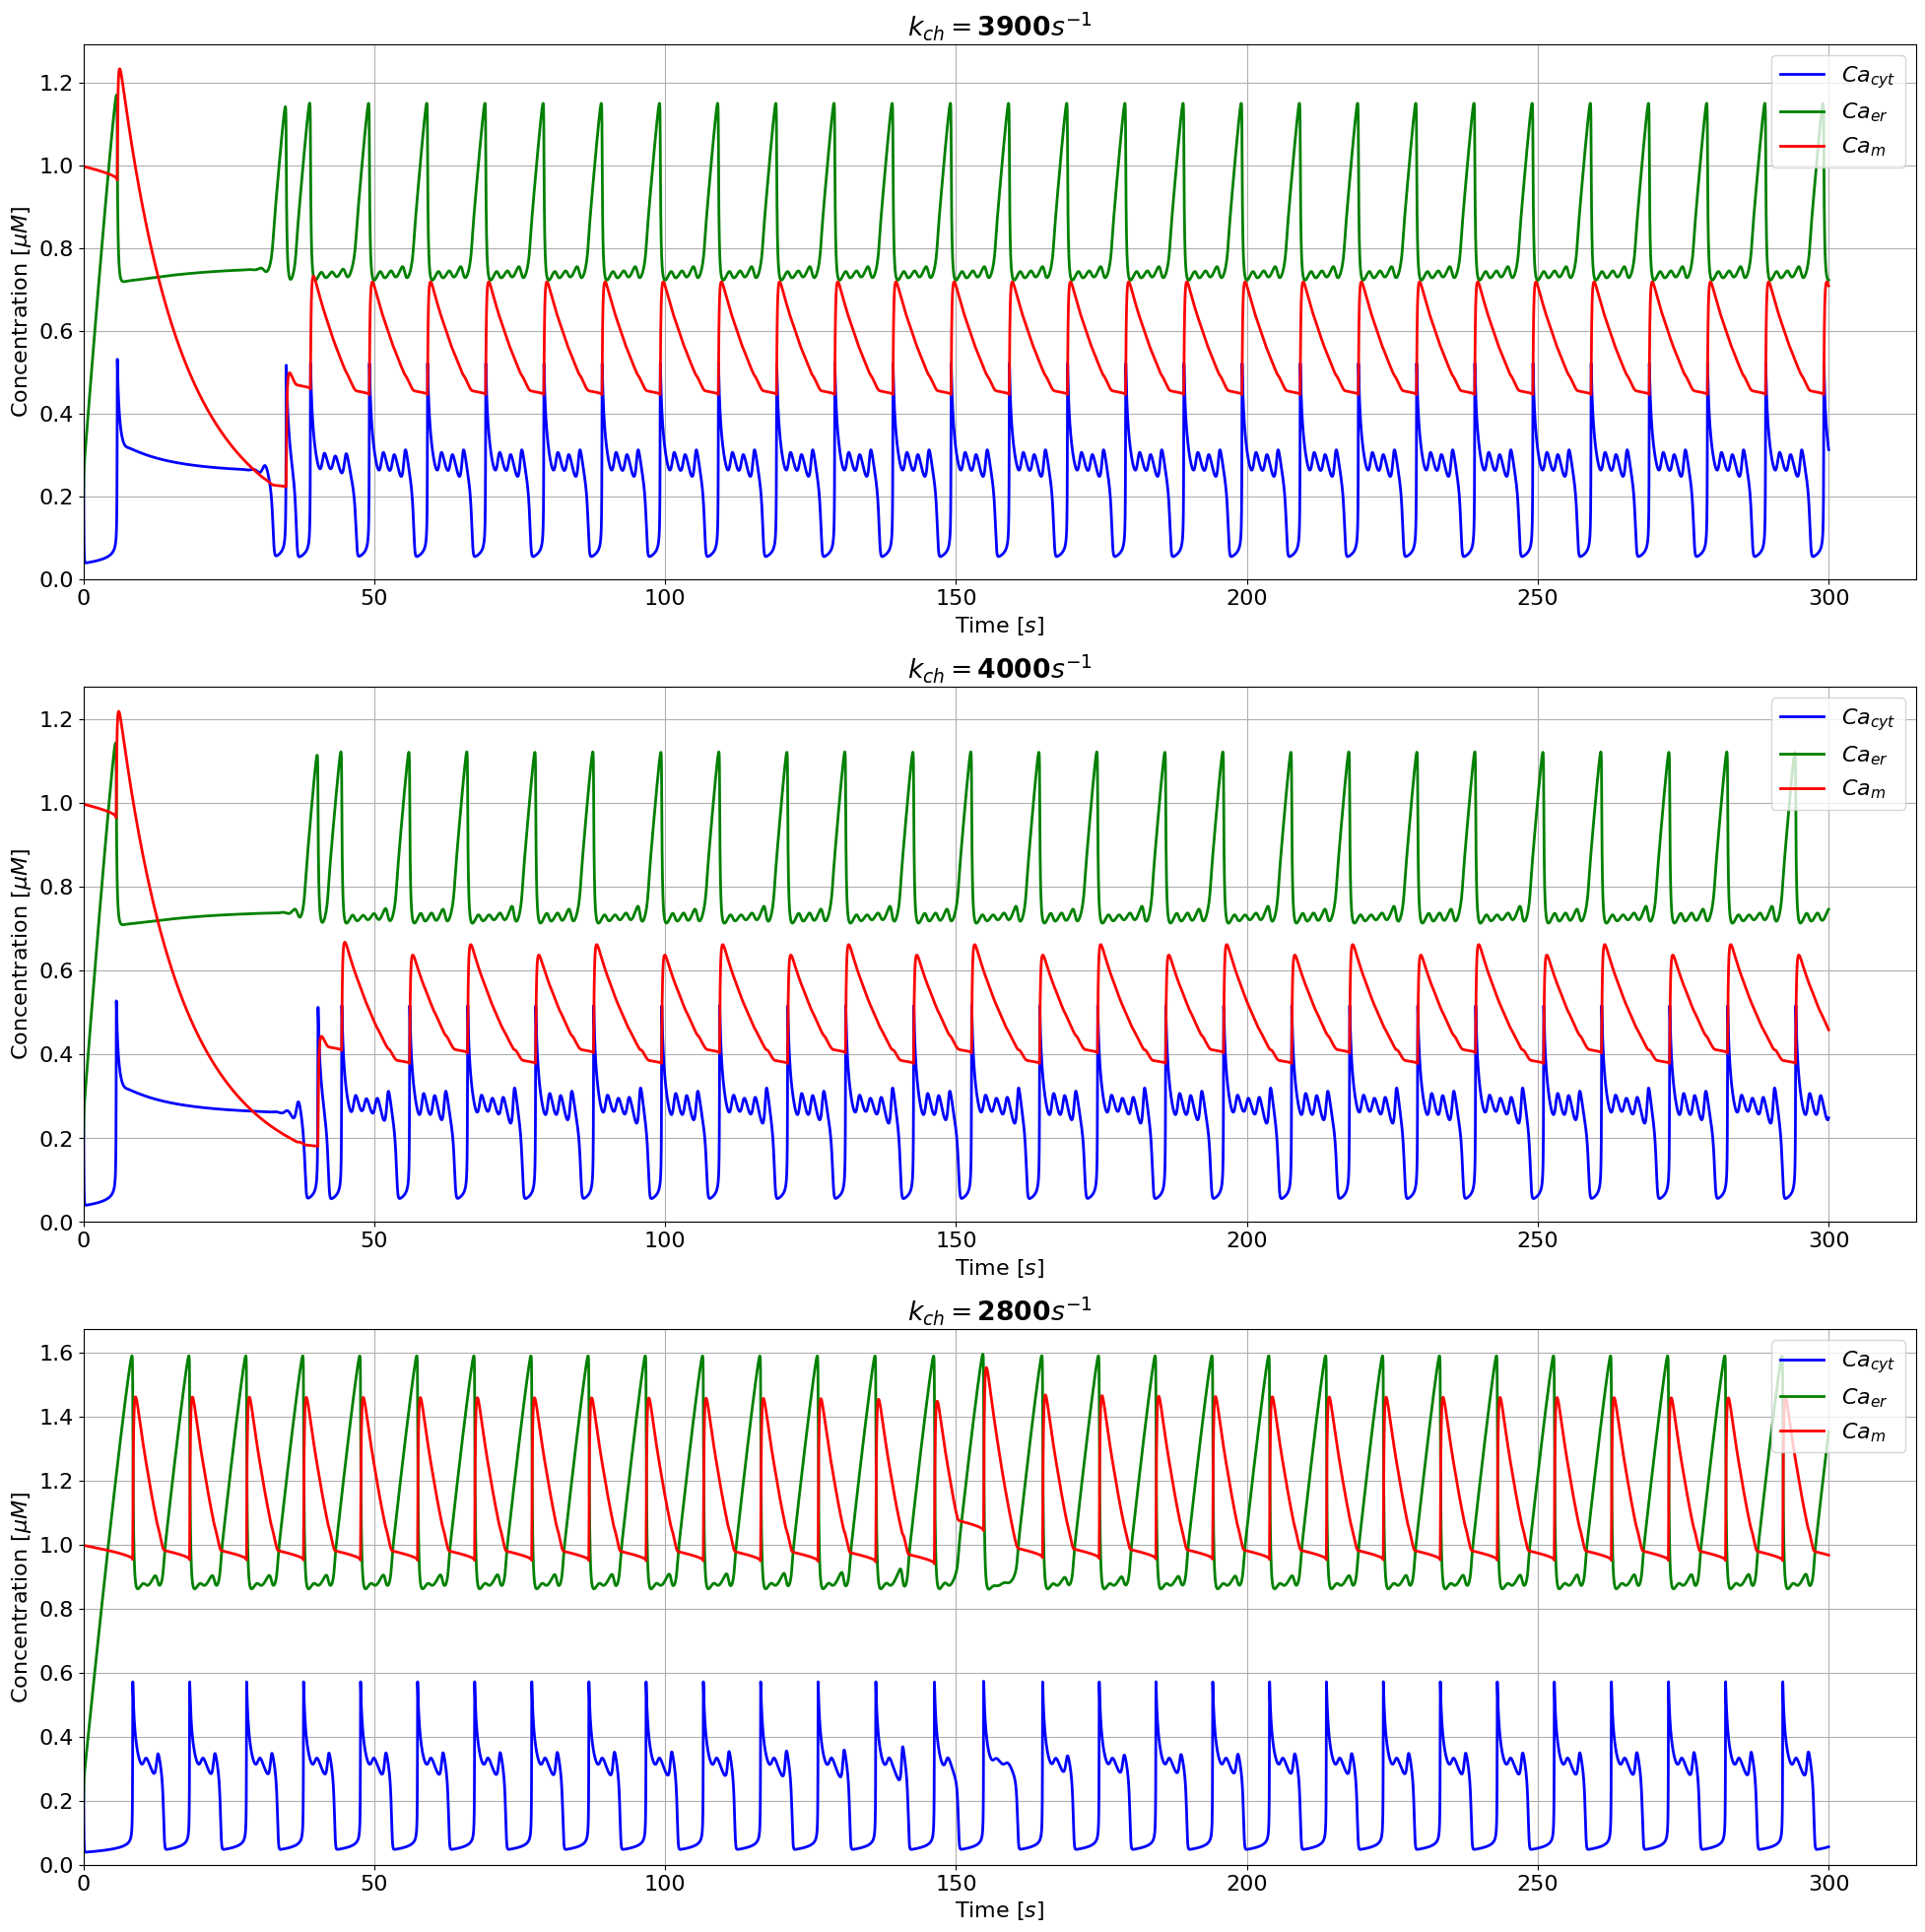

In [7]:
plt.rcParams.update({"font.size" : 16})

fig, axes = plt.subplots(3,1,figsize=(24,24))

for (ax, k_ch) in zip(axes.flatten(), k_chs):

    params = { "k_ch" : k_ch }

    # Solutions
    sol = odeint(calcium_model, ca0, t, args=(params, ))
    ca_cyt, ca_er, ca_m = sol[:, 0], sol[:, 1], sol[:, 2]

    # Plotting
    ax.plot(t, ca_cyt, label=r"$Ca_{cyt}$", c="blue", lw=2)
    ax.plot(t, ca_er, label=r"$Ca_{er}$", c="green", lw=2)
    ax.plot(t, ca_m, label=r"$Ca_{m}$", c="red", lw=2)

    ax.set_xlabel(r"Time $[s]$")
    ax.set_ylabel(r"Concentration $[\mu M]$")

    ax.set_title(r"$k_{ch} = $" + f"{k_ch}" + r"$s^{-1}$", fontweight='bold')

    ax.set_xlim(0,)
    ax.set_ylim(0,)

    ax.legend()
    ax.grid()

plt.show()

### f) & g)

**Description for $k_{ch} = 3900 s^{-1}$**

At the initial stage of the system (up untill $t \approx 40$), the model seems to stabilize and adjust the concentrations to the provided model parameters. First, $CaPr$ complexes dissociate in the cytosol and most of the cytosolic calcium is pumped into the ER, creating a spike. This calcium is quickly released through the ER membrane channels, causing a quick subsequent spikes in both the cytosolic and mitochondrial calcium. When sequestration in mitochondria ends and the concentration reaches a peak, the calcium begins to slowly leak up untill $t \approx 40$. Some of the cytosolic calcium is bound into the proteins, causing a rapid drop. After the release, ER calcium almost stabilizes and there are no major changes untill the oscillation period, which begins at $t \approx 40$.

The oscillations in calcium concentrations can be divided into three phases. The ER release phase, when the ER calcium quickly drops, and causes a rapid subsequent spike in cytosolic and mitochondrial calcium. The bursting phase, when the mitochondrial calcium steadily decreases at a much slower rate, than it increased during ER release phase. Finally, the silent phase, when the $CaPr$ complexes dissociate and resulting free calcium molecules are pumped into the ER. For simplification, these phases will be referred to as Phase I, Phase II and Phase III, respectively.

In Phase I, ER calcium rapidly drops, while the cytosolic and mitochondrial calcium rapidly concentration rapidly increases. Calcium release from the ER is the dominating process in Phase I. Efflux from the ER, most of which occurs through the membrane channels, quickly increases the concentration in the surrounding cytosol. As described in the theoretical analysis of the system, a large part of this released cytosolic calcium is then rapdily sequestered into the mitochondria. This results in the spike in mitochondrial calcium.

In Phase II, mitochondrial calcium is steadily (but not linearly) decreasing. Slow mitochondrial leakage is the dominating process of Phase II. This phase is much longer than Phase I, which goes in line with the fact that calcium uptake is much faster than its release in the mitochondria. Calcium ions are transferred from mitochondria to cytosolic proteins, allowing for binding and creation of $CaPr$ complexes. This is a long term process, during which occurs another, faster, process - the exchange of calcium between the ER and cytosolic proteins. The combined effect of this exchange and binding are small calcium spikes and bursting oscillations visible on the plot in cytosolic and ER concentrations.

Finally, in phase III, the silent phase, is governed by the dissociation of accumulated $CaPr$ complexes in the cytosol. Concentration of this complexes rapidly drops (not shown on the plot) resulting in many free calcium molecules and unbounded protein sites. The dissociation process is again accompanied by a fast absorption of calcium from the cytosol into the ER, causing a quick spike and drop in cytosolic and ER calcium, respectively.

### h)

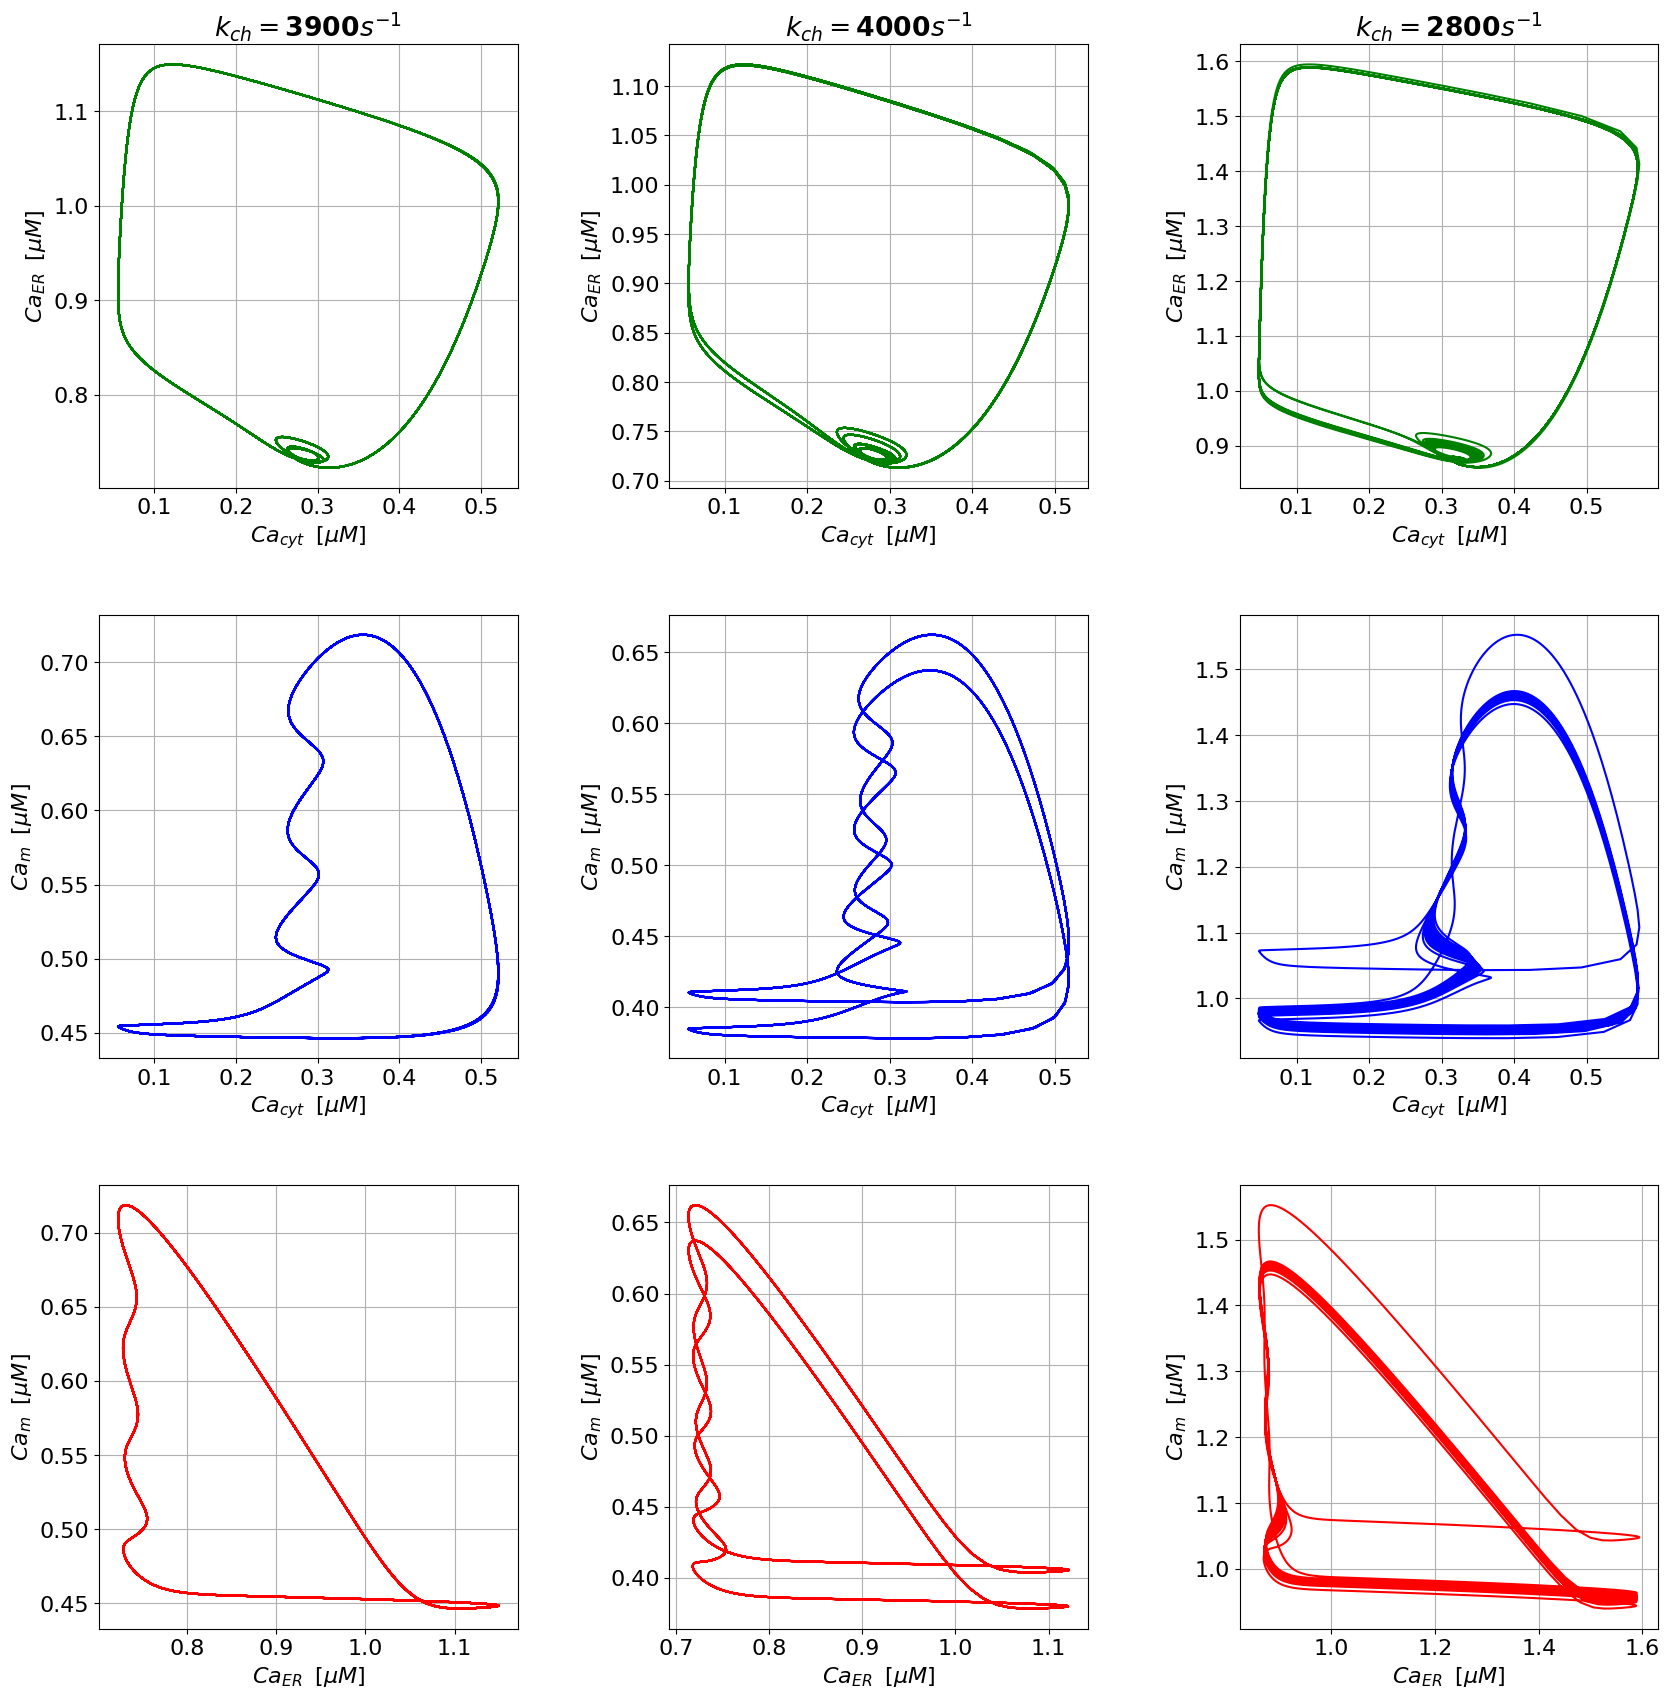

In [ ]:
# Phase plots
fig, axes = plt.subplots(3,3,figsize=(18,18))
fig.tight_layout(pad=4.0)

# Index for cutoff of initial phase, where oscillations begin
osc_start = int(0.2 * t.shape[0])

for (i, k_ch) in enumerate(k_chs):

    params = { "k_ch" : k_ch }

    # Solutions
    sol = odeint(calcium_model, ca0, t, args=(params, ))
    ca_cyt, ca_er, ca_m = sol[:, 0], sol[:, 1], sol[:, 2]

    # Cut the results to only include the oscillations
    t_osc = t[osc_start:]
    ca_cyt_osc, ca_er_osc, ca_m_osc = ca_cyt[osc_start:], ca_er[osc_start:], ca_m[osc_start:]

    # Plotting
    axes[0,i].plot(ca_cyt_osc, ca_er_osc, c="green")
    axes[0,i].set_xlabel(r"$Ca_{cyt} \; \; [\mu M]$")
    axes[0,i].set_ylabel(r"$Ca_{ER} \; \; [\mu M]$")
    axes[0,i].grid()

    axes[1,i].plot(ca_cyt_osc, ca_m_osc, c="blue")
    axes[1,i].set_xlabel(r"$Ca_{cyt} \; \; [\mu M]$")
    axes[1,i].set_ylabel(r"$Ca_{m} \; \; [\mu M]$")
    axes[1,i].grid()

    axes[2,i].plot(ca_er_osc, ca_m_osc, c="red")
    axes[2,i].set_xlabel(r"$Ca_{ER} \; \; [\mu M]$")
    axes[2,i].set_ylabel(r"$Ca_{m} \; \; [\mu M]$")
    axes[2,i].grid()

    axes[0,i].set_title(r"$k_{ch} = $" + f"{k_ch}" + r"$s^{-1}$", fontweight='bold')

plt.show()

### i)

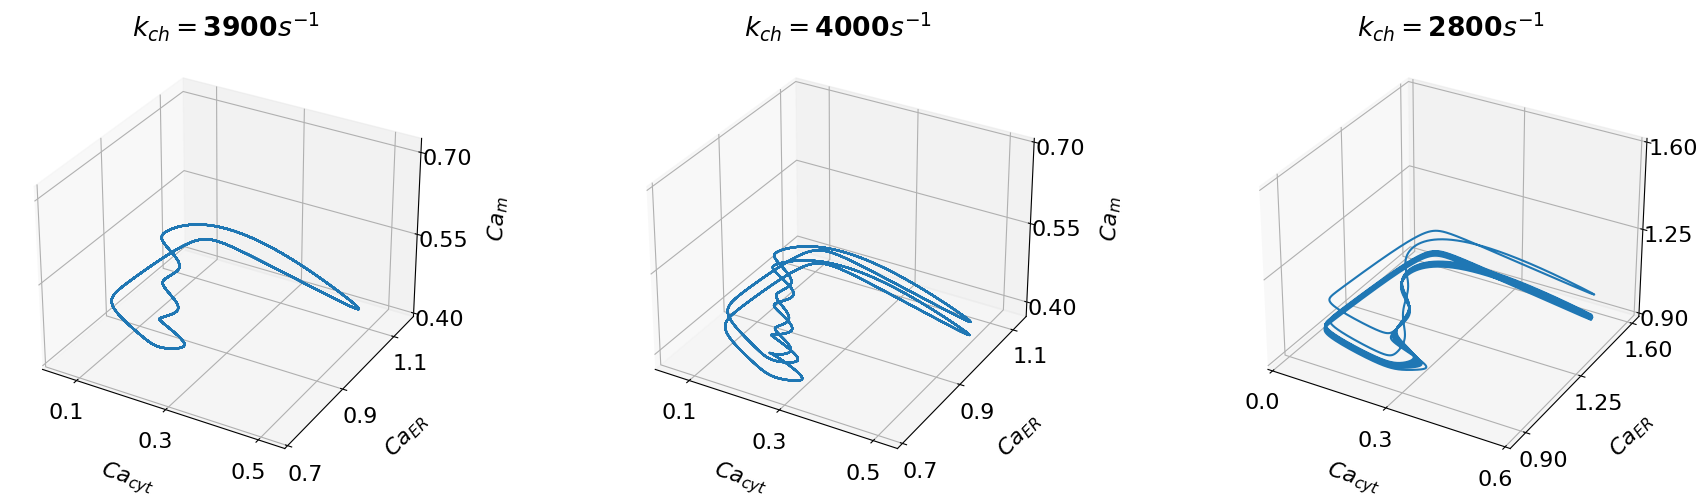

In [ ]:
plt.rcParams.update({"font.size" : 16})
fig = plt.figure(figsize=1.4*plt.figaspect(0.25))

# TODO: Fix cutoff of zlabel on 3rd plot

for (i, k_ch) in enumerate(k_chs):
    ax = fig.add_subplot(1,3,i+1,projection="3d")

    params = { "k_ch" : k_ch }

    # Solutions
    sol = odeint(calcium_model, ca0, t, args=(params, ))
    ca_cyt, ca_er, ca_m = sol[:, 0], sol[:, 1], sol[:, 2]

    # Cut the results to only include the oscillations
    t_osc = t[osc_start:]
    ca_cyt_osc, ca_er_osc, ca_m_osc = ca_cyt[osc_start:], ca_er[osc_start:], ca_m[osc_start:]

    # Plotting
    cmap = plt.get_cmap()
    ax.plot(ca_cyt_osc, ca_er_osc, zs=ca_m_osc, lw=1.5)

    ax.set_xlabel(r"$Ca_{cyt}$", labelpad=15)
    ax.set_ylabel(r"$Ca_{ER}$", labelpad=15)
    ax.set_zlabel(r"$Ca_{m}$", labelpad=15)

    ax.set_xticks(np.linspace(np.round(np.min(ca_cyt_osc), 1), np.round(np.max(ca_cyt_osc), 1), 3))
    ax.set_yticks(np.linspace(np.round(np.min(ca_er_osc), 1), np.round(np.max(ca_er_osc), 1), 3))
    ax.set_zticks(np.linspace(np.round(np.min(ca_m_osc), 1), np.round(np.max(ca_m_osc), 1), 3))

    ax.set_title(r"$k_{ch} = $" + f"{k_ch}" + r"$s^{-1}$", fontweight='bold')

plt.show()

# Question 2: Schnakenberg model

### a) & b)

Nature is full of examples of formation of complex and unique patterns, with researchers dedicating entire books to this particular topic. Notable examples involve plants (Lindenmayer & Prusinkiewicz, 1990) sea shells (Meinhardt, 1995) or sponges and corals (Kaandorp & Kübler, 2001). The fundamental question in computational and fundamental biology is how this vast range of pattern and structure is formed from an almost uniformly homogeneous fertilized egg. In 1952, Alan Turing hypothesized that these patterns can form due to the pre-formed configuration and intereaction of biochemicals called morphogens. The system proposed by Turing (**ADD REF**) conditioned the time-dependent change of a vector of morphogens $u$ on the diffusion term (the Laplace term) and the reaction interchemical kinetics.

$$
\begin{equation}
    \frac{\delta u}{\delta t} = \mathbf{D} \nabla^{2} \mathbf{u} + \mathbf{f(u)}
\end{equation}
$$

The Schnakenberg model (**ADD REF**) is a specific realisation of the system proposed by Turing, with two morphogens interacting with each other. The $D_u$ and $D_v$ are their respective diffusion constants or the rates at which chemicals disperse in space. Parameters $c_1, c_{-1}, c_2, c_3$ represent the reaction rates occuring in the system. Schnakenberg developed his kinematic reaction model in search for a minimal chemically sensible exhitbiting a limit-cycle behaviour i.e. temporal periodic solutions ("Pattern formation analysis in Schnakenberg model", Beentjes 2014). It is based on reactions between four general chemicals $X, A, B, Y$ and can be derived by making the assumption that A, B are constant. In the corresponding reaction kinetics model (**ADD REF**), $X$ engages in a reversible conversion to $A$, $B$ converts irreversibly to $Y$ and a pair of $X$ molecules bind with $Y$ to create an $X$ triplet. After writing down four corresponding time derivatives for chemical concentration the law of mass action and assuming constant $A$ and $B$: $\frac{\delta [A]}{\delta t} = \frac{\delta [B]}{\delta t} = 0$ we arrive at the Schnakenberg model (**ADD REF**).

$$
\begin{equation}
    X \xrightleftharpoons[k_1]{k_{-1}} A \hspace{1cm} B \xrightharpoonup[]{k_2} Y \hspace{1cm} 2X + Y \xrightharpoonup[]{k_3} 3X 
\end{equation}
$$

$$
\begin{equation}
\begin{split}
    \frac{\delta u}{\delta t} &= D_u \nabla^{2} \mathbf{u} + c_1 - c_{-1} u + c_3 u^2 v \\
    \frac{\delta v}{\delta t} &= D_v \nabla^{2} \mathbf{v} + c_2 - c_3 u^2 v
\end{split}
\end{equation}
$$

### c) & d)

In [41]:
def laplacian_1d(z, dx):
    """
    Approximates the Laplacian using finite difference method and periodic boundary conditions.
    - z  := vector to take the Laplacian for
    - dx := lattice step
    """
    return (np.roll(z, 1) + np.roll(z, -1) - 2*z) / (dx**2)


def run_schnakenberg_model_1d(u0, v0, dt, nt, params):
    """
    Runs the Schnakenberg model.
    - u0 := initial state of chemical u
    - v0 := initial state of chemical v
    - dt := time step
    - nt := no. of simulation steps
    """

    # Rename the chemical vectors for clarity
    u = u0
    v = v0
    
    # Checking validity of input parameters
    acceptable_names = [ "cp1", "cm1", "c2", "c3", "Du", "Dv", "L", "N"]
    
    for param in params.keys():
        assert param in acceptable_names

    # Initializing model parameters as given by input or to default values
    cp1 = params["cp1"] if "cp1" in params else 0.1
    cm1 = params["cm1"] if "cm1" in params else 1.0
    c2 = params["c2"] if "c2" in params else 0.9
    c3 = params["c3"] if "c3" in params else 1
    Du = params["Du"] if "Du" in params else 0.0004
    Dv = params["Dv"] if "Dv" in params else 0.016
    L = params["L"] if "L" in params else 1
    N = params["N"] if "N" in params else 100

    # Validate provided N is consistent with u0 and v0
    assert u0.shape == (N, )
    assert v0.shape == (N, )

    # Calculate lattice step
    dx = (L / N)

    # Run the simulation
    for i in range(nt):
        unew = u + dt * (Du * laplacian_1d(u, dx) + cp1 - cm1 * u + c3*(u**2 * v))
        vnew = v + dt * (Dv * laplacian_1d(v, dx) + c2 - c3*(u**2 * v))

        u = unew
        v = vnew

    return u, v

In [42]:
# Model parameters, note that other parameters are assigned by default inside the method itself
N = 100
dt = 0.001
tmax = 35
nt_tot = int(tmax / dt)

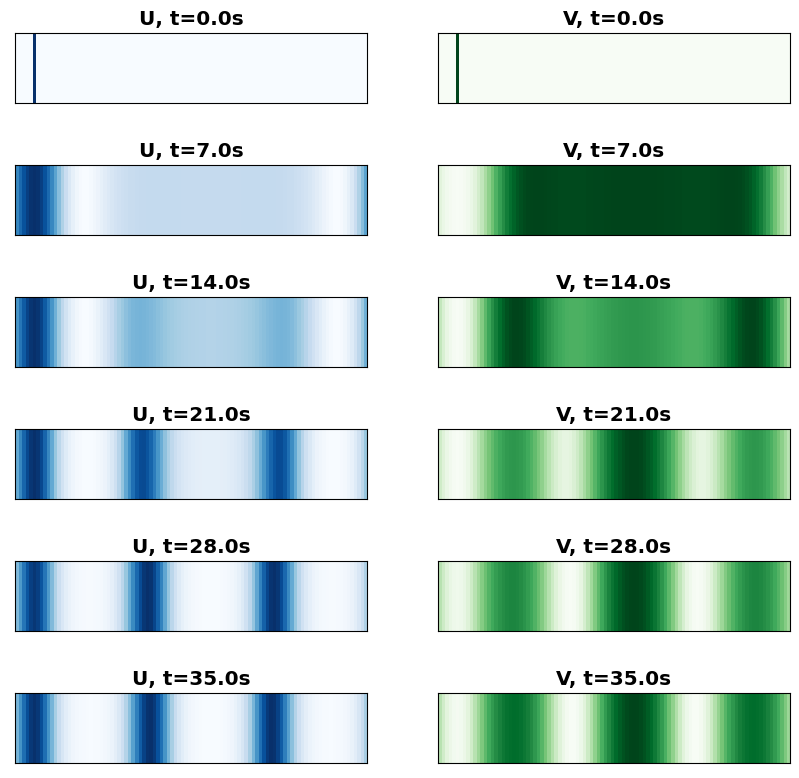

In [43]:
# Initial conditions
u0 = np.zeros(N)
v0 = np.zeros(N)

u0[5] = 1
v0[5] = 3

# Plots at five evenly spaced steps
nt = int(nt_tot / 5)
u, v = u0, v0

fig, axes = plt.subplots(6,2,figsize=(10,10))
plt.rcParams.update({"font.size" : 12})

for i in range(6):
    # Plotting
    axes[i,0].imshow(u.reshape(1,N), aspect=20, cmap='Blues')
    axes[i,1].imshow(v.reshape(1,N), aspect=20, cmap='Greens')

    axes[i,0].set_xticks([])
    axes[i,1].set_xticks([])

    axes[i,0].set_yticks([])
    axes[i,1].set_yticks([])

    axes[i,0].set_title(f"U, t={i*nt*dt}s", fontweight='bold')
    axes[i,1].set_title(f"V, t={i*nt*dt}s", fontweight='bold')

    u0, v0 = u, v

    # Simulation
    u, v = run_schnakenberg_model_1d(u0, v0, dt, nt, {})

plt.show()

### f) & g)

In [3]:
def laplacian_2d(z, dx):
    """
    Approximates the 2D Laplacian using finite difference method and periodic boundary conditions.
    - z  := vector to take the Laplacian for
    - dx := lattice step
    """
    return (np.roll(z, 1, axis=0) + np.roll(z, -1, axis=0) +
            np.roll(z, 1, axis=1) + np.roll(z, -1, axis=1) -
            4*z) / (dx**2)


def run_schnakenberg_model_1d(u0, v0, dt, nt, params):
    """
    Runs the Schnakenberg model.
    - u0 := initial state of chemical u
    - v0 := initial state of chemical v
    - dt := time step
    - nt := no. of simulation steps
    """

    # Rename the chemical vectors for clarity
    u = u0
    v = v0
    
    # Checking validity of input parameters
    acceptable_names = [ "cp1", "cm1", "c2", "c3", "Du", "Dv", "L", "N"]
    
    for param in params.keys():
        assert param in acceptable_names

    # Initializing model parameters as given by input or to default values
    cp1 = params["cp1"] if "cp1" in params else 0.1
    cm1 = params["cm1"] if "cm1" in params else 1.0
    c2 = params["c2"] if "c2" in params else 0.9
    c3 = params["c3"] if "c3" in params else 1
    Du = params["Du"] if "Du" in params else 0.0004
    Dv = params["Dv"] if "Dv" in params else 0.016
    L = params["L"] if "L" in params else 1
    N = params["N"] if "N" in params else 100

    # Validate provided N is consistent with u0 and v0
    assert u0.shape == (N, N)
    assert v0.shape == (N, N)

    # Calculate lattice step
    dx = (L / N)

    # Run the simulation
    for i in range(nt):
        unew = u + dt * (Du * laplacian_2d(u, dx) + cp1 - cm1 * u + c3*(u**2 * v))
        vnew = v + dt * (Dv * laplacian_2d(v, dx) + c2 - c3*(u**2 * v))

        u = unew
        v = vnew

    return u, v

In [4]:
# Model parameters, note that other parameters are assigned by default inside the method itself
N = 100
dt = 0.001
tmax = 35
nt_tot = int(tmax / dt)

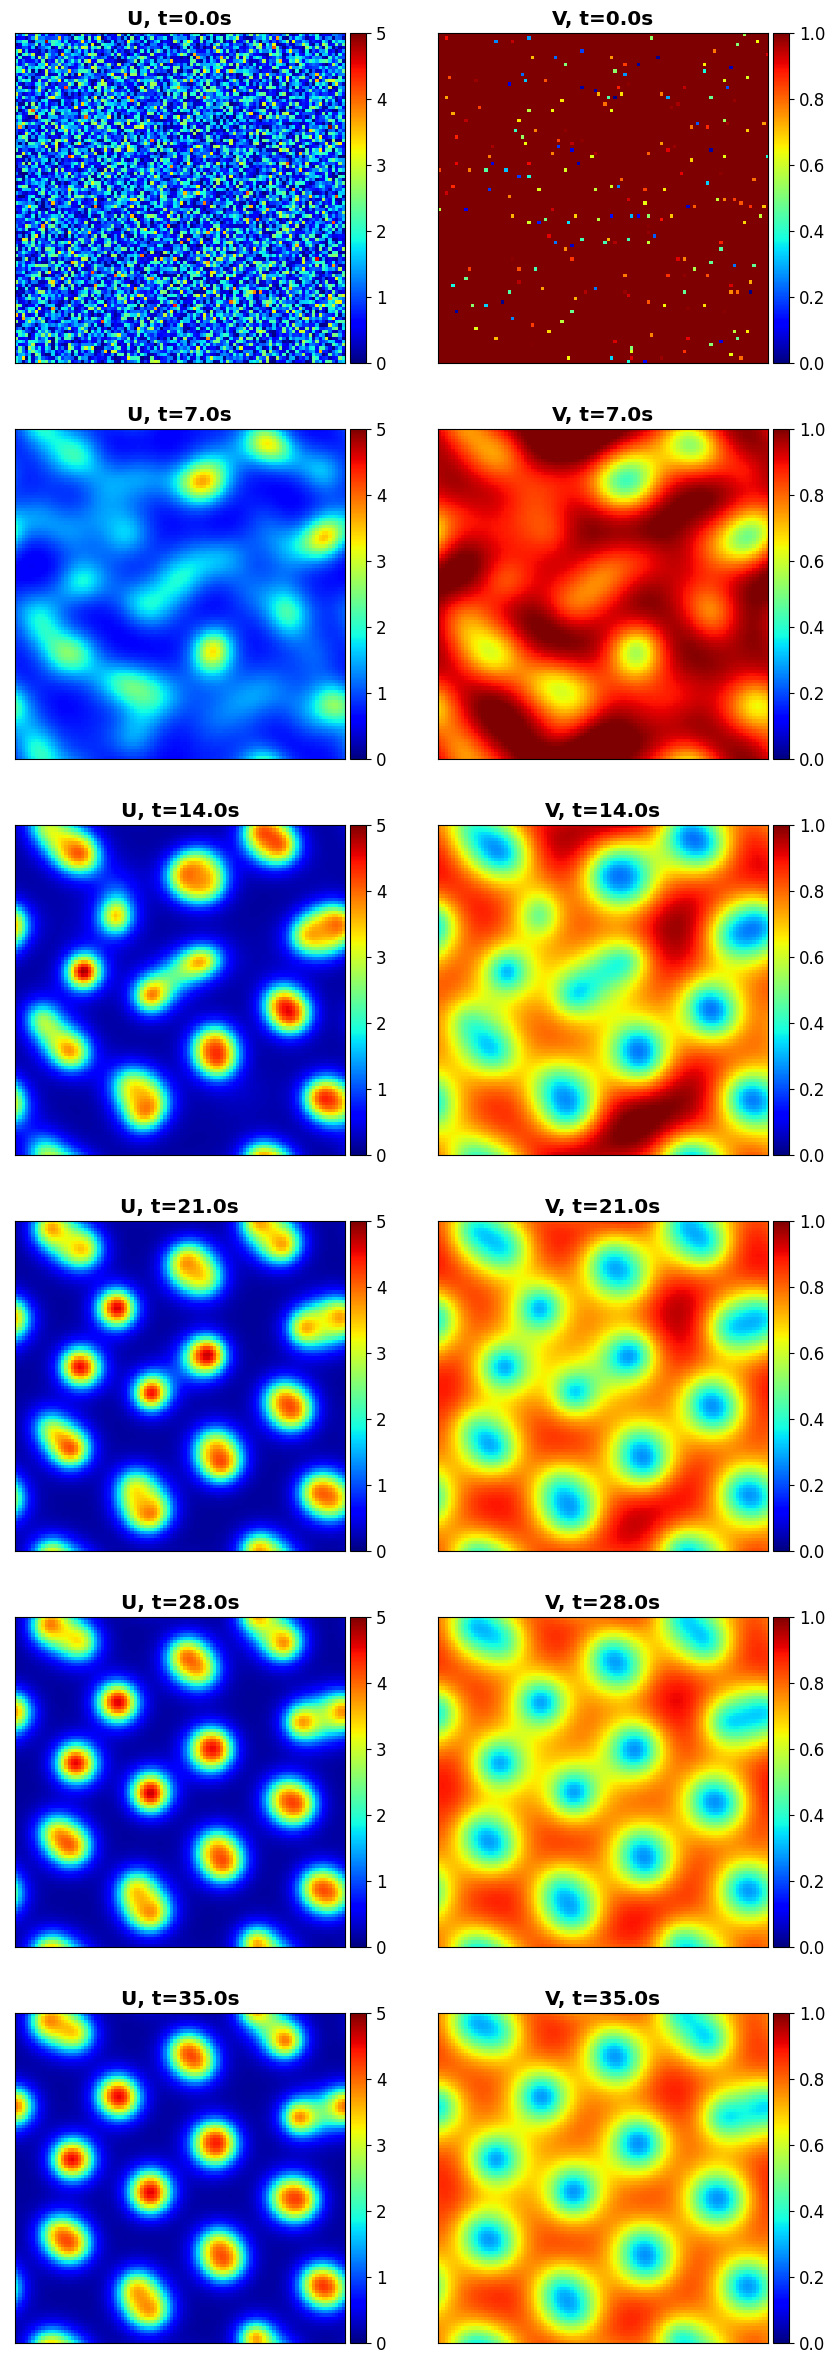

In [5]:
# Initial conditions

u0 = np.abs(np.random.normal(loc=1, size=(N, N)))
v0 = np.abs(np.random.normal(loc=3, size=(N, N)))

# Plots at five evenly spaced steps
nt = int(nt_tot / 5)
u, v = u0, v0

fig, axes = plt.subplots(6,2,figsize=(10,30))
plt.rcParams.update({"font.size" : 12})

for i in range(6):
    # Plotting
    im = axes[i,0].imshow(u, cmap='jet', vmin=0, vmax=5)
    divider = make_axes_locatable(axes[i,0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    im = axes[i,1].imshow(v, cmap='jet', vmin=0, vmax=1)
    divider = make_axes_locatable(axes[i,1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

    axes[i,0].set_xticks([])
    axes[i,1].set_xticks([])

    axes[i,0].set_yticks([])
    axes[i,1].set_yticks([])

    axes[i,0].set_title(f"U, t={i*nt*dt}s", fontweight='bold')
    axes[i,1].set_title(f"V, t={i*nt*dt}s", fontweight='bold')

    u0, v0 = u, v

    # Simulation
    u, v = run_schnakenberg_model_1d(u0, v0, dt, nt, { "N": N })

plt.savefig
plt.show()